In [1]:
!git clone 'https://github.com/aakashvardhan/s7-in-depth-practice.git'

Cloning into 's7-in-depth-practice'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 142 (delta 71), reused 116 (delta 45), pack-reused 0
Receiving objects: 100% (142/142), 339.57 KiB | 13.06 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
import sys
sys.path.append('/content/s7-in-depth-practice')
sys.path.append('/content/s7-in-depth-practice/models')

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from model_utils import model_summary, test_model_sanity, sgd_optimizer
from models.model import model3

from utils import train, test, get_device, plt_fig, get_incorrect_predictions, plot_incorrect

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.Resize((28, 28)),
                                      transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 223531338.18it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105980484.54it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 199725399.16it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4489872.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# CUDA?
cuda = get_device()

# For reproducibility
torch.manual_seed(1)

if torch.cuda.is_available():
    torch.cuda.manual_seed(1)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
model3 = model3().to(cuda)

In [8]:
model_summary(model3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
              ReLU-2            [-1, 4, 26, 26]               0
       BatchNorm2d-3            [-1, 4, 26, 26]               8
           Dropout-4            [-1, 4, 26, 26]               0
         ConvBlock-5            [-1, 4, 26, 26]               0
            Conv2d-6            [-1, 8, 24, 24]             288
              ReLU-7            [-1, 8, 24, 24]               0
       BatchNorm2d-8            [-1, 8, 24, 24]              16
           Dropout-9            [-1, 8, 24, 24]               0
        ConvBlock-10            [-1, 8, 24, 24]               0
           Conv2d-11           [-1, 16, 22, 22]           1,152
             ReLU-12           [-1, 16, 22, 22]               0
      BatchNorm2d-13           [-1, 16, 22, 22]              32
          Dropout-14           [-1, 16,

In [9]:
from torch.optim.lr_scheduler import StepLR


optimizer = sgd_optimizer(model3, 0.04)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
EPOCHS = 15
lr = []
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model3, cuda, train_loader, optimizer, epoch)
    test(model3, cuda, test_loader)
    scheduler.step()
    lr.append(optimizer.param_groups[0]['lr'])

EPOCH: 1


Loss=0.08434382826089859 Batch_id=468 Accuracy=86.18: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]



Test set: Average loss: 0.0588, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.0978543683886528 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:42<00:00, 10.97it/s]



Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.03732876852154732 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:42<00:00, 10.91it/s]



Test set: Average loss: 0.0367, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.06504508852958679 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]



Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.12743593752384186 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:42<00:00, 11.01it/s]



Test set: Average loss: 0.0338, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.10384466499090195 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:45<00:00, 10.38it/s]



Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.06468028575181961 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]



Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.02633192390203476 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:43<00:00, 10.84it/s]



Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.022920353338122368 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.031964439898729324 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:43<00:00, 10.84it/s]



Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.13113215565681458 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:42<00:00, 10.97it/s]



Test set: Average loss: 0.0168, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.05126373469829559 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]



Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.06044589355587959 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:43<00:00, 10.88it/s]



Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.02426617406308651 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:43<00:00, 10.69it/s]



Test set: Average loss: 0.0171, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.0379183366894722 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]



Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)



In [10]:
# Save model
torch.save(model3.state_dict(), 'best_model.pth')

In [18]:
from utils import train_losses, test_losses, train_acc, test_acc

print(train_losses)
print(test_losses)
print(train_acc)
print(test_acc)

[tensor(2.3083, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2982, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.3000, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2905, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2817, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2600, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2666, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2378, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2251, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.1857, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.1734, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.1509, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.1319, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.1000, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.0246, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.1061, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.0451, device='

In [23]:
[train_loss.cpu().detach().numpy() for train_loss in train_losses]

[array(2.308262, dtype=float32),
 array(2.298224, dtype=float32),
 array(2.30002, dtype=float32),
 array(2.2905014, dtype=float32),
 array(2.2817109, dtype=float32),
 array(2.259973, dtype=float32),
 array(2.26662, dtype=float32),
 array(2.2378428, dtype=float32),
 array(2.2251077, dtype=float32),
 array(2.1857114, dtype=float32),
 array(2.173352, dtype=float32),
 array(2.1509352, dtype=float32),
 array(2.1319015, dtype=float32),
 array(2.0999901, dtype=float32),
 array(2.0245821, dtype=float32),
 array(2.1060824, dtype=float32),
 array(2.045062, dtype=float32),
 array(2.0474017, dtype=float32),
 array(1.9958812, dtype=float32),
 array(1.9062738, dtype=float32),
 array(2.0271897, dtype=float32),
 array(1.796848, dtype=float32),
 array(1.7634691, dtype=float32),
 array(1.837265, dtype=float32),
 array(1.8320701, dtype=float32),
 array(1.6850026, dtype=float32),
 array(1.7956852, dtype=float32),
 array(1.6344411, dtype=float32),
 array(1.6242595, dtype=float32),
 array(1.6838814, dtype=f

Text(0.5, 1.0, 'Test Accuracy')

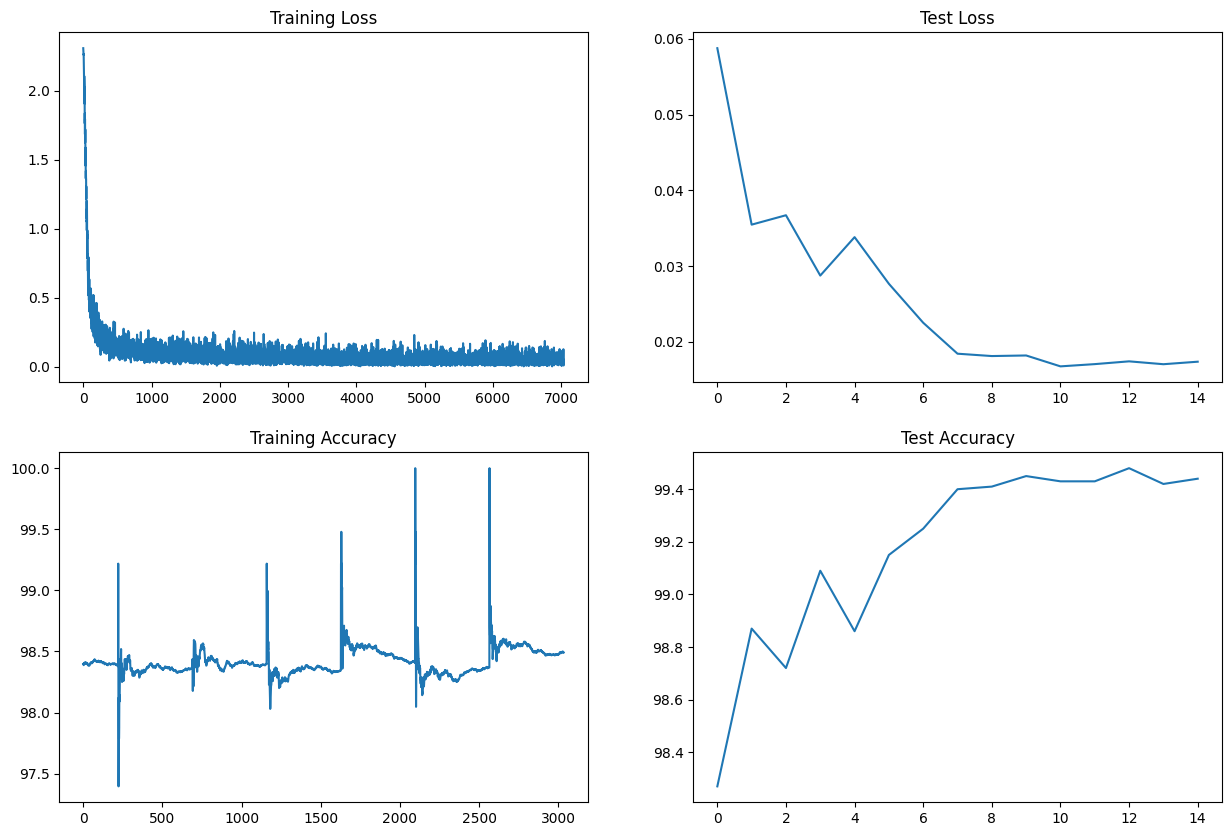

In [22]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([train_loss.cpu().detach().numpy() for train_loss in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")